In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f1rpozmt
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-f1rpozmt
  Resolved https://github.com/tensorflow/docs to commit 07d04bd3afd508f827ba4001660dda76086dfab9
  Preparing metadata (setup.py) ... done
ERROR: Package 'tensorflow-docs' requires a different Python: 3.7.12 not in '>=3.8'


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import imageio
import os
import pathlib
import time
import glob
from IPython import display

#### Data

In [6]:
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 6s 0us/step


In [7]:
images = train_images.astype('float32')
images = (images - 127.5) / 127.5

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
image_ds = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### Display some images

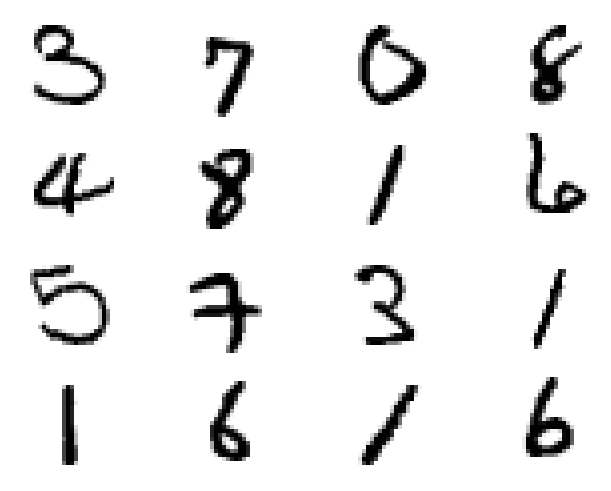

In [11]:
image_batch = next(iter(image_ds))

fig, ax = plt.subplots(nrows=4, ncols=4, constrained_layout=True)
ax = ax.ravel()

for i, frame in enumerate(ax):
  frame.imshow(image_batch[i], cmap=plt.cm.binary)
  frame.axis(False)


## Generator


The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). 

Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of `28x28x1`. 

Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses `tanh`.

In [12]:
def make_generator_model():
  return tf.keras.Sequential([
      tf.keras.layers.Dense(units=7*7*256, use_bias=False, input_shape=(100,)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Reshape((7,7,256)),

      # [7,7,256] --> [7,7,128]
      tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      # [7,7,128] --> [14,14,128]
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      # [14,14,128] --> [28,28,1]
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'),

  ])

In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

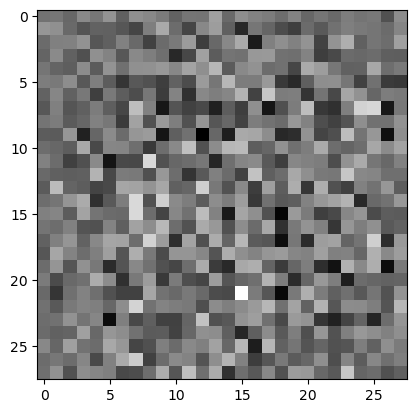

In [15]:
noise = tf.random.normal((1,100))
generated_images = generator(noise)
plt.imshow(generated_images[0], cmap='binary');

## Discriminator

The discriminator is a CNN-based image classifier.



In [16]:
def make_discriminator_model():
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(28,28,1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1)
  ])

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                      

In [18]:
logits = discriminator(generated_images)
logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00092689]], dtype=float32)>

## Loss and Optimizer

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### The Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. 

It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [20]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

#### The generator's loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).

In [21]:
def generator_loss(fake_output):
 return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [23]:
checkpoint_dir = pathlib.Path('./checkpoint')
checkpoint_prefix = checkpoint_dir/"{epoch}.ckpt"

checkpoint = tf.train.Checkpoint(
    generator=generator, discriminator=discriminator,
    generator_optimizer=generator_optimizer,  discriminator_optimizer=discriminator_optimizer)

## Training

In [24]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

noise_seed = tf.random.normal(shape=[num_examples_to_generate, noise_dim])

In [25]:
@tf.function
def train_step(images):
  noise_batch = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_images = generator(noise_batch, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))

  return {'generator_loss':gen_loss, 'discriminator_loss':disc_loss}


In [26]:
def generate_and_save_image(gen_model, epoch, noise_batch, title):

  prediction = gen_model(noise_batch, training=False)

  fig, ax = plt.subplots(nrows=4, ncols=4, constrained_layout=True)
  ax = ax.ravel()

  for i, frame in enumerate(ax):
    frame.imshow(prediction[i], cmap=plt.cm.binary)
    frame.axis(False)
  fig.suptitle(title)
  plt.savefig(f'Image_at_epoch:{epoch}.png')
  plt.show()



In [27]:
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()

def training(dataset, epochs):

  for epoch in range(epochs):

    gen_metric.reset_state()
    disc_metric.reset_state()
    start = time.time()

    for image_batch in dataset:
      loss_obj = train_step(image_batch)
      gen_metric.update_state(loss_obj["generator_loss"])
      disc_metric.update_state(loss_obj["discriminator_loss"])
    
    if epoch%15==0:
      checkpoint.save(file_prefix=str(checkpoint_prefix).format(epoch=epoch))

    display.clear_output(wait=True)
    message = f'Epoch : {epoch} | Generator loss : {gen_metric.result() :0.2f} | Discriminator Loss : {disc_metric.result() :0.2f}'
    generate_and_save_image(generator, epoch, noise_seed, message)
    print(f'Epoch:{epoch} completed, time elapsed:{time.time()-start :0.2f}s')



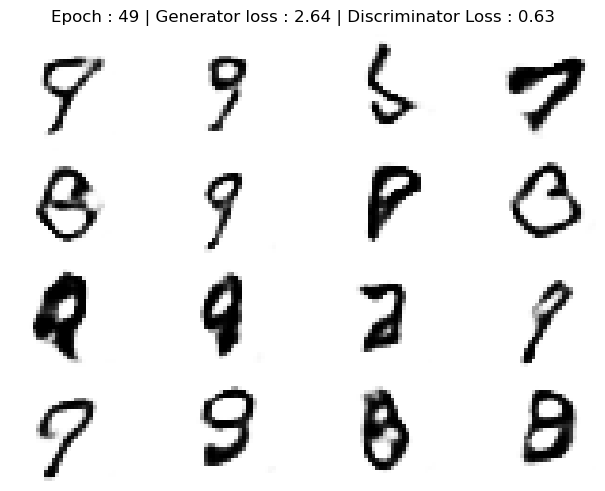

Epoch:49 completed, time elapsed:8.81s


In [28]:
training(image_ds, EPOCHS)

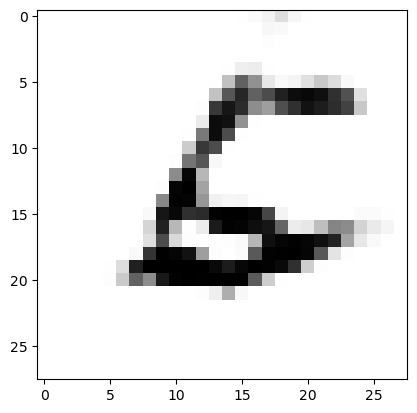

In [36]:
noise = tf.random.normal((1,100))
generated_images = generator(noise)
plt.imshow(generated_images[0]*127.5+127.5, cmap='binary');

## Create a GIF

In [48]:
def display_saved_images(epoch_num):
   return PIL.Image.open(f'Image_at_epoch:{epoch_num}.png')

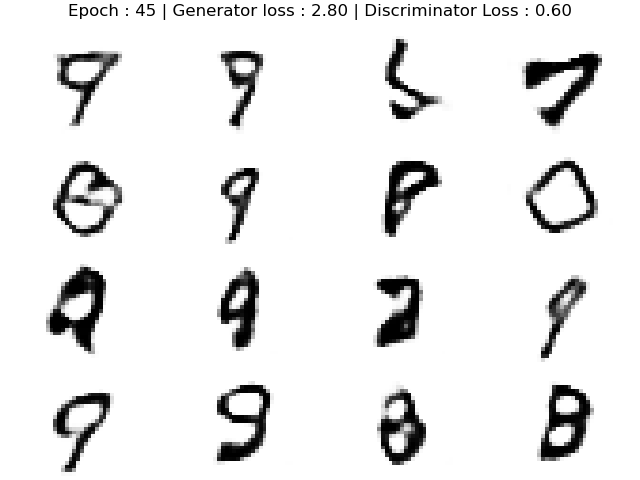

In [49]:
display_saved_images(45)

Use imageio to create an animated gif using the images saved during training.

In [56]:
filename='dcgan.gif'
saved_images = sorted([i for i in  pathlib.Path('.').glob('*.png')])
with imageio.get_writer(filename,mode='I') as writer:
    for img_path in saved_images:
        img = imageio.imread(img_path)
        writer.append_data(img)
    
    img = imageio.imread(img_path)
    writer.append_data(img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [62]:
! ls

Image_at_epoch:0.png   Image_at_epoch:25.png  Image_at_epoch:41.png
Image_at_epoch:1.png   Image_at_epoch:26.png  Image_at_epoch:42.png
Image_at_epoch:10.png  Image_at_epoch:27.png  Image_at_epoch:43.png
Image_at_epoch:11.png  Image_at_epoch:28.png  Image_at_epoch:44.png
Image_at_epoch:12.png  Image_at_epoch:29.png  Image_at_epoch:45.png
Image_at_epoch:13.png  Image_at_epoch:3.png   Image_at_epoch:46.png
Image_at_epoch:14.png  Image_at_epoch:30.png  Image_at_epoch:47.png
Image_at_epoch:15.png  Image_at_epoch:31.png  Image_at_epoch:48.png
Image_at_epoch:16.png  Image_at_epoch:32.png  Image_at_epoch:49.png
Image_at_epoch:17.png  Image_at_epoch:33.png  Image_at_epoch:5.png
Image_at_epoch:18.png  Image_at_epoch:34.png  Image_at_epoch:6.png
Image_at_epoch:19.png  Image_at_epoch:35.png  Image_at_epoch:7.png
Image_at_epoch:2.png   Image_at_epoch:36.png  Image_at_epoch:8.png
Image_at_epoch:20.png  Image_at_epoch:37.png  Image_at_epoch:9.png
Image_at_epoch:21.png  Image_at_epoch:38.png  __noteb

<img src="dcgan.gif" width="750" align="center">